# SVM Comparison
This notebook runs a comparison between ThunderSVM and Falkon on 3 multi-class classification datasets:
 - SVHN
 - CIFAR10
 - MNIST

The datasets are all of *moderate* size and we will observe that ThunderSVM is fast but suffers from bad scaling with the number of points: on the larger datasets Falkon is much faster than TSVM, but not on the smaller datasets.

[ThunderSVM](https://github.com/Xtra-Computing/thundersvm) is a GPU-accelerated SVM solver. It runs on a single GPU so also Falkon was run on only 1 GPU.

Note that running the notebook as-is may not work since Falkon uses the PyTorch GPU allocator and ThunderSVM does not, so it may happen that -- depending on who runs first -- the other algorithm fails since it does not have enough memory. If this happens restart the notebook and run one of the two methods.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import *
from scipy import sparse
import scipy
import numpy as np
from thundersvm import *
from sklearn import svm
import time

In [3]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("../benchmark")
sys.path.append("../falkon")

In [4]:
RANDOM_SEED = 91
import functools

from datasets import get_load_fn
from error_metrics import get_err_fns
from benchmark_utils import *

import torch
from falkon import kernels, Falkon, InCoreFalkon, FalkonOptions

## Runner Functions

In [46]:
def run_libsvm(Xtr, Xts, Ytr, Yts, sigma, C, err_fn):
    gamma = 1/(2*sigma**2)
    tsvm = svm.SVC(C=C, gamma=gamma, kernel='rbf', verbose=True)
    t_s = time.time()
    tsvm.fit(Xtr.numpy(), Ytr.argmax(1))
    t_e = time.time()
    preds = tsvm.predict(Xts.numpy())
    test_err, test_err_name = err_fn(Yts, torch.from_numpy(preds.reshape(-1, 1)))
    print("LIBSVM elapsed %.2fs" % (t_e - t_s))
    print(f"Sigma {sigma} - C {C} - "
          f"Test {test_err_name}: {test_err:9.6f}", flush=True)
    return test_err, t_e - t_s

def run_thundersvm(Xtr, Xts, Ytr, Yts, sigma, C, err_fn):
    gamma = 1/(2*sigma**2)
    tsvm = SVC(C=C, gamma=gamma, kernel='rbf', verbose=True)
    t_s = time.time()
    tsvm.fit(Xtr.numpy(), Ytr.argmax(1))
    t_e = time.time()
    preds = tsvm.predict(Xts.numpy())
    test_err, test_err_name = err_fn(Yts, torch.from_numpy(preds.reshape(-1, 1)))
    print("THUNDERSVM elapsed %.2fs" % (t_e - t_s))
    print(f"Sigma {sigma} - C {C} - "
          f"Test {test_err_name}: {test_err:9.6f}", flush=True)
    return test_err, t_e - t_s

def run_flk(Xtr, Xts, Ytr, Yts, sigma, penalty, M, num_iter, err_fn):
    # Arguments
    k = kernels.GaussianKernel(sigma)
    opt = FalkonOptions(compute_arch_speed=False, no_single_kernel=True, pc_epsilon_32=1e-6, debug=False)
    flk = Falkon(
        kernel=k,
        penalty=penalty,
        M=M,
        maxiter=num_iter,
        seed=1234-21,
        error_fn=err_fn,
        error_every=1,
        options=opt
    )
    t_s = time.time()
    flk.fit(Xtr, Ytr, Xts, Yts)
    t_e = time.time()
    test_preds = flk.predict(Xts).cpu()
    test_err, test_err_name = err_fn(Yts, test_preds)
    print("Falkon elapsed %.2fs" % (t_e - t_s))
    print(f"M {M} - Sigma {sigma} - Lambda {penalty} - "
          f"Test {test_err_name}: {test_err:9.6f}", flush=True)
    return test_err, t_e - t_s


def run_flk_incore(Xtr, Xts, Ytr, Yts, sigma, penalty, M, num_iter, err_fn, do_test=False):
    # Arguments
    k = kernels.GaussianKernel(sigma)
    opt = FalkonOptions(compute_arch_speed=False, no_single_kernel=True, pc_epsilon_32=1e-6, debug=False)
    flk = InCoreFalkon(
        kernel=k,
        penalty=penalty,
        M=M,
        maxiter=num_iter,
        seed=1234-21,
        error_fn=err_fn if not do_test else None,
        error_every=1,
        options=opt
    )
    t_s = time.time()
    Xtr = Xtr.cuda()
    Ytr = Ytr.cuda()
    Xts = Xts.cuda()
    Yts = Yts.cuda()
    flk.fit(Xtr, Ytr, Xts, Yts)
    t_e = time.time()
    test_preds = flk.predict(Xts).cpu()
    test_err, test_err_name = err_fn(Yts, test_preds)
    print("Falkon elapsed %.2fs" % (t_e - t_s))
    print(f"M {M} - Sigma {sigma} - Lambda {penalty} - "
          f"Test {test_err_name}: {test_err:9.6f}", flush=True)
    return test_err, t_e - t_s

## MNIST

In [6]:
dset = Dataset.MNIST_SMALL
Xtr, Ytr, Xts, Yts, kwargs = get_load_fn(dset)(dtype=np.float32, as_torch=True)
m = torch.mean(Xtr)
s = torch.std(Xtr)
Xtr -= m
Xtr /= s
Xts -= m
Xts /= s

Loaded MNIST dataset in <class 'numpy.float32'> precision.
Split the data into 60000 training, 10000 validation points of dimension 780.
Data-preprocessing completed.


In [47]:
err_fns = get_err_fns(dset)
err_fns = [functools.partial(fn, **kwargs) for fn in err_fns]

if True:
    mnist_err_flk, mnist_time_flk = run_flk_incore(
        Xtr, Xts, Ytr, Yts, sigma=19.8, penalty=5e-9, M=20000, num_iter=5, err_fn=err_fns[0], do_test=True)
    print("\n\n")
if False:
    mnist_err_flk, mnist_time_flk = run_flk(
        Xtr, Xts, Ytr, Yts, sigma=24, penalty=1e-9, M=20000, num_iter=5, err_fn=err_fns[0])
    print("\n\n")
if False:
    mnist_err_thund, mnist_time_thund = run_thundersvm(
        Xtr, Xts, Ytr, Yts, sigma=15, C=100, err_fn=err_fns[0])
    print("\n\n")
if False:
    mnist_err_libs, mnist_time_libs = run_libsvm(
        Xtr, Xts, Ytr, Yts, sigma=15, C=100, err_fn=err_fns[0])
    print("\n\n")

Falkon elapsed 6.52s
M 20000 - Sigma 19.8 - Lambda 5e-09 - Test c-error:  0.135700





##### In-Core Falkon
 - elapsed 6.52s
 - M 20000 - Sigma 19.8 - Lambda 5e-09 - Test c-error:  0.135700

##### Falkon 
 - elapsed 10.85s
 - M 20000 - Sigma 24 - Lambda 1e-09 - Test c-error:  0.137600

##### THUNDERSVM
 - elapsed 19.55s
 - Sigma 15 - C 100 - Test c-error:  0.134700
 
##### LIBSVM 
 - elapsed 660.99s
 - Sigma 15 - C 100 - Test c-error:  0.134500

## SVHN

In [48]:
dset = Dataset.SVHN
Xtr, Ytr, Xts, Yts, kwargs = get_load_fn(dset)(dtype=np.float32, as_torch=True)
err_fns = get_err_fns(dset)
err_fns = [functools.partial(fn, **kwargs) for fn in err_fns]

Loaded SVHN dataset in <class 'numpy.float32'> precision.
Split the data into 73257 training, 26032 validation points of dimension 1024.
Data-preprocessing completed.


In [51]:
if True:
    svhn_err_flkic, svhn_time_flkic = run_flk_incore(
         Xtr, Xts, Ytr, Yts, sigma=5, penalty=5e-7, M=20000, num_iter=5, err_fn=err_fns[0], do_test=True)
if False:
    svhn_err_flk, svhn_time_flk = run_flk(
        Xtr, Xts, Ytr, Yts, sigma=5, penalty=5e-7, M=20000, num_iter=5, err_fn=err_fns[0])
if False:
    svhn_err_thund, svhn_time_thund = run_thundersvm(
        Xtr, Xts, Ytr, Yts, sigma=5, C=20, err_fn=err_fns[0])
if False:
    svhn_err_thund, svhn_time_thund = run_libsvm(
        Xtr, Xts, Ytr, Yts, sigma=5, C=20, err_fn=err_fns[0])

Falkon elapsed 7.85s
M 20000 - Sigma 5 - Lambda 5e-07 - Test c-error:  0.231830


##### THUNDERSVM
 - elapsed 166.44s
 - Sigma 5 - C 20 - Test c-error:  0.234673

##### Falkon 
 - elapsed 17.20s
 - M 20000 - Sigma 5 - Lambda 5e-07 - Test c-error:  0.231062
 
#### In-Core Falkon
 - elapsed 7.85s
 - M 20000 - Sigma 5 - Lambda 5e-07 - Test c-error:  0.231830

## CIFAR10

In [52]:
dset = Dataset.CIFAR10
Xtr, Ytr, Xts, Yts, kwargs = get_load_fn(dset)(dtype=np.float32, as_torch=True)
err_fns = get_err_fns(dset)
err_fns = [functools.partial(fn, **kwargs) for fn in err_fns]

Loaded CIFAR10 dataset in <class 'numpy.float32'> precision.
Split the data into 50000 training, 10000 validation points of dimension 1024.
Data-preprocessing completed.


In [53]:
if True:
    cifar_err_flkic, cifar_time_flkic = run_flk_incore(
        Xtr, Xts, Ytr, Yts, sigma=5, penalty=2e-6, M=20000, num_iter=5, err_fn=err_fns[0], do_test=False)
if False:
    cifar_err_flk, cifar_time_flk = run_flk(
        Xtr, Xts, Ytr, Yts, sigma=5, penalty=2e-6, M=20000, num_iter=5, err_fn=err_fns[0])
if False:
    cifar_err_thund, cifar_time_thund = run_thundersvm(
        Xtr, Xts, Ytr, Yts, sigma=5, C=5, err_fn=err_fns[0])

Iteration   1 - Elapsed 3.9s - validation c-error: 0.5352
Iteration   2 - Elapsed 4.6s - validation c-error: 0.5221
Iteration   3 - Elapsed 5.0s - validation c-error: 0.5191
Iteration   4 - Elapsed 5.5s - validation c-error: 0.5195
Iteration   5 - Elapsed 5.9s - validation c-error: 0.5188
Falkon elapsed 6.72s
M 20000 - Sigma 5 - Lambda 2e-06 - Test c-error:  0.518800


##### Falkon 
 - elapsed 13.68s
 - M 20000 - Sigma 5 - Lambda 2e-06 - Test c-error:  0.519000

##### THUNDERSVM 
 - elapsed 82.92s
 - Sigma 5 - C 5 - Test c-error:  0.519800
 
#### In-Core Falkon
 - elapsed 6.72s
 - M 20000 - Sigma 5 - Lambda 2e-06 - Test c-error:  0.518800

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
import math
print(math.sqrt(128*2**30 / 4))
print(math.sqrt(10*2**30 / 4))

185363.80004736633
51810.75718419873


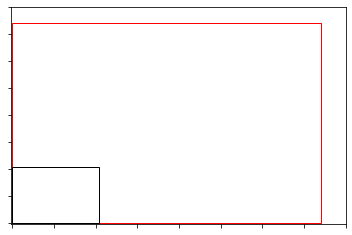

In [17]:
fig, ax = plt.subplots()

rect1 = patches.Rectangle((0,0),185_000, 185_000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((0,0),51810, 51810,linewidth=1,edgecolor='k',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

ax.set_xlim([-1000, 200_000])
ax.set_ylim([-1000, 200_000])
ax.set_xticklabels([])
_ = ax.set_yticklabels([])